In [1]:
import psycopg2
import getpass
#Соединение с базой данных (нужно ввести пароль). Последняя строка - проверка установленного соединения.
conn = psycopg2.connect(user = 'postgres', database = 'postgres', host = 'localhost', port = '5432',
                        password = getpass.getpass('Введите пароль: '))
print(conn.get_dsn_parameters())

Введите пароль:  ···········


{'user': 'postgres', 'channel_binding': 'prefer', 'dbname': 'postgres', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'disable', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'}


In [16]:
#Импорт библиотек для работы

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import matplotlib.dates as mdt

In [87]:
# Входные данные, задаваемые пользователем для сравнения двух бондов по спреду доходностей
exch_me = 'Московская Биржа'
isin_1 = 'RU000A0JRXT1'
isin_2 = 'RU000A0JT213'
date_1 = '2015-01-01'
date_2 = '2015-07-01'

In [88]:
# Изначально роисходит заполнение подготовленного SQL-запроса данными пользователя 
# (по каждой бумаге по-отдельности). Получаем 2 таблицы.

with open('compare_bonds.sql', 'r', encoding='utf-8') as f:
                query_1 = (f.read()).format(isin = isin_1, exch = exch_me, date_1 = date_1, date_2 = date_2) 
with open('compare_bonds.sql', 'r', encoding='utf-8') as f:
                query_2 = (f.read()).format(isin = isin_2, exch = exch_me, date_1 = date_1, date_2 = date_2) 
df_1 = pd.read_sql(query_1, conn)
df_2 = pd.read_sql(query_2, conn)

# Средний спред доходности по каждой облигации 

avg_1 = round(df_1['spread'].mean(), 3)
avg_2 = round(df_2['spread'].mean(), 3)

avg_points_1 = [avg_1 for i in range(len(df_1.date_trading))]
avg_points_2 = [avg_2 for i in range(len(df_2.date_trading))]

# Количество наблюдений
n = df_1.date_trading.count()

# Квантиль уровня 0.25 для спреда доходности каждой облигации
quant25_1 = np.quantile(df_1.spread, 0.25)
quants_1 = [quant25_1 for i in range(len(df_1.date_trading))]

quant25_2 = np.quantile(df_2.spread, 0.25)
quants_2 = [quant25_2 for i in range(len(df_2.date_trading))]

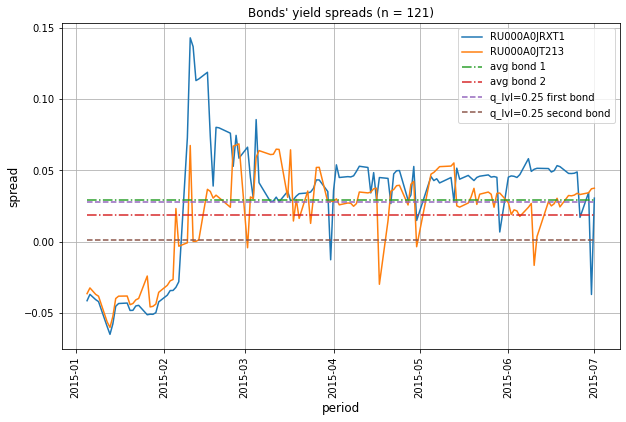

In [120]:
# Строится график, где будут отображаться данные по обеим облигациям. 

plt.figure(figsize=(10, 6))
plt.plot(df_1.date_trading, df_1.spread, label = isin_1)
plt.plot(df_2.date_trading, df_2.spread, label = isin_2)

# Название графика, где в скобках указано количество наблюдений
plt.title("Bonds' yield spreads"+" (n = "+str(n)+")")

# Наименования осей и размер шрифта
plt.xlabel('period', fontsize = 12)
plt.ylabel('spread', fontsize = 12)

# Вертикальное отображение дат, чтобы избежать наложения друг на друга
plt.xticks(rotation='vertical')

# Построение средних линий спреда доходности по облигациям
plt.plot(df_1.date_trading, avg_points_1, label = "avg bond 1", linestyle = "-.")
plt.plot(df_2.date_trading, avg_points_2, label = "avg bond 2", linestyle = "-.")

# Построение квантилей уровня 0.25
plt.plot(df_1.date_trading, quants_1, label = "q_lvl=0.25 first bond", linestyle = "--")
plt.plot(df_2.date_trading, quants_2, label = "q_lvl=0.25 second bond", linestyle = "--")

# Добавление сетчатой разметки и легенды, где указаны isin облигаций, а также их средние и квантили
plt.grid()
plt.legend()

# Пользователь задает путь, куда сохранить график
path = r'C:\Users\Public\graph1.png'
plt.savefig(path)

In [136]:
# Задание данных для получения объема торгов на определенном временном интервале на выбранной бирже в указанной валюте

exch_me = 'Московская Биржа'
dat_1 = '2015-06-01'
dat_2 = '2015-08-01'
currency = 'RUB'

# Аналогичные операции, описанные для примера выше, только используется уже не 2 таблицы, а одна.

with open('volume.sql', 'r', encoding='utf-8') as f:
                query = (f.read()).format(exch_me, dat_1, dat_2, currency) 
df = pd.read_sql(query, conn)

mean_v = df.volume.mean()
mean_vol = [mean_v for i in range(df.volume.count())]

n = df.volume.count()

quant25 = np.quantile(df.volume, 0.25)
quant_25 = [quant25 for i in range(len(df.dt))]

quant75 = np.quantile(df.volume, 0.75)
quant_75 = [quant75 for i in range(len(df.dt))]

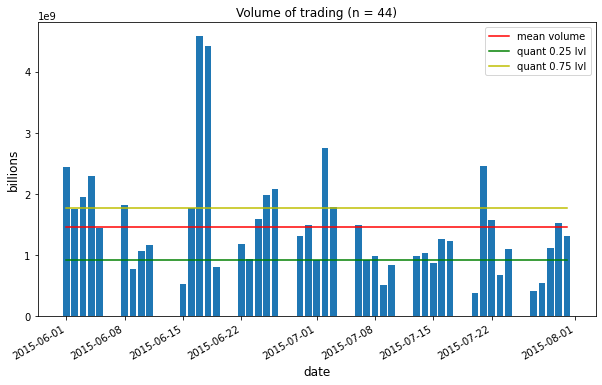

In [140]:
# Построение столбчатой диаграммы, где изображена динамика объема торгов по датам.
plt.figure(figsize=(10, 6))
plt.bar(df.dt, df.volume)
plt.title("Volume of trading"+" (n = "+str(n)+")")
plt.xlabel('date', fontsize = 12)
plt.ylabel('billions', fontsize = 12)

plt.gcf().autofmt_xdate()

plt.plot(df.dt, mean_vol, color = 'r', label = 'mean volume')

plt.plot(df.dt, quant_25, color = 'g', label = "quant 0.25 lvl")
plt.plot(df.dt, quant_75, color = 'y', label = "quant 0.75 lvl")
         
plt.legend()

# Пользователь задает путь, куда сохранить график
path = r'C:\Users\Public\graph2.png'
plt.savefig(path)

In [173]:
# Получить бид-аск спред по некоторой бумаге с заданной периодичностью (period) 
# на определенной бирже на временном интервале. Сперва получаем таблицу за весь период (не учитываем интервал)
period = 4
exch_me = 'Московская Биржа'
dt_1 = '2015-01-01'
dt_2 = '2015-12-31'
isin = 'RU000A0JT213'
with open('get_BAS.sql', 'r', encoding='utf-8') as f:
                quer = (f.read()).format(exch_me, dt_1, dt_2, isin) 
df = pd.read_sql(quer, conn)

# Получаем новую таблицу с наблюдениями, соответствующими интервалу. 
# Статистические показатели расчитываются как для примера 1.
df_period = df[pd.to_datetime(df.date_trading).dt.strftime("%Y%m%d").astype(int) % period == 0]

mean_bs = df_period.bas.mean()
mean_bas = [mean_bs for i in range(df_period.bas.count())]

n = df_period.bas.count()

quant25 = np.quantile(df_period.bas, 0.25)
quant_25 = [quant25 for i in range(len(df_period.date_trading))]

quant75 = np.quantile(df_period.bas, 0.75)
quant_75 = [quant75 for i in range(len(df_period.date_trading))]

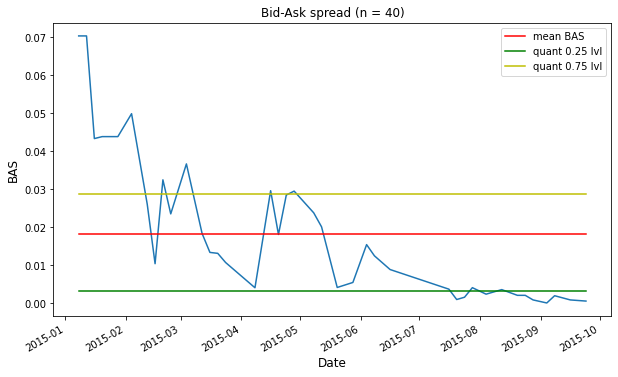

In [175]:
# Построение графика изменения бид-аск спреда с заданным интервалом. 
plt.figure(figsize=(10, 6))
plt.plot(df_period.date_trading, df_period.bas)

plt.title("Bid-Ask spread"+" (n = "+str(n)+")")
plt.xlabel('Date', fontsize = 12)
plt.ylabel('BAS', fontsize = 12)

# Автоматическая настройка даты на оси
plt.gcf().autofmt_xdate()

plt.plot(df_period.date_trading, mean_bas, color = 'r', label = 'mean BAS')

plt.plot(df_period.date_trading, quant_25, color = 'g', label = "quant 0.25 lvl")
plt.plot(df_period.date_trading, quant_75, color = 'y', label = "quant 0.75 lvl")
         
plt.legend()

# Пользователь задает путь, куда сохранить график
path = r'C:\Users\Public\graph3.png'
plt.savefig(path)